In [1]:
import json
import os
import pandas as pd
import numpy as np
import prettytable as pt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import dates
import datetime
import warnings
warnings.filterwarnings("ignore")


###################################################################################################
                                                                                                  #
from rhoova.Client import *                                                                       #   
#Register and get api key from https://app.rhoova.com/ for ClientConfig("api key", "api secret")  #
config = ClientConfig("", "")                                                                     #
api = Api(config)                                                                                 # 
                                                                                                  #
###################################################################################################



directory = os.path.normpath(os.getcwd() + os.sep + os.pardir + os.sep + os.pardir)
datadirectory=directory+"/data/yielddata.csv"

yielddata = pd.read_csv(datadirectory)
yielddata = yielddata.replace(np.nan, '', regex=True) 

mdirectory = os.path.normpath(os.getcwd() + os.sep + os.pardir + os.sep + os.pardir)
mdatadirectory=mdirectory+"/data/marketdata.csv"

marketdata = pd.read_csv(mdatadirectory)
marketdata = marketdata.replace(np.nan, '', regex=True) 


In [2]:
fixedRateBondDefinition={}
fixedRateBondDefinition["issueDate"]="2015-03-15"
fixedRateBondDefinition["maturityDate"]="2026-06-04"
fixedRateBondDefinition["frequency"]="Semiannual"
fixedRateBondDefinition["coupon"]=0.085
fixedRateBondDefinition["calendar"]="Turkey"
fixedRateBondDefinition["currency"]="TRY"
fixedRateBondDefinition["dateGeneration"]="Backward"
fixedRateBondDefinition["dayCounter"]="Actual360"
fixedRateBondDefinition["businessDayConvention"]="ModifiedFollowing"
fixedRateBondDefinition["maturityDateConvention"]="ModifiedFollowing"
fixedRateBondDefinition["redemption"]=100
fixedRateBondDefinition["endOfMonth"]=True
fixedRateBondDefinition

{'issueDate': '2015-03-15',
 'maturityDate': '2026-06-04',
 'frequency': 'Semiannual',
 'coupon': 0.085,
 'calendar': 'Turkey',
 'currency': 'TRY',
 'dateGeneration': 'Backward',
 'dayCounter': 'Actual360',
 'businessDayConvention': 'ModifiedFollowing',
 'maturityDateConvention': 'ModifiedFollowing',
 'redemption': 100,
 'endOfMonth': True}

In [3]:
instruments={}
depo={}
irs={}

depo["businessDayConvention"]="Following"     # if it is null, default value is used
depo["dayCounter"]="Actual360"                # if it is null, default value is used

irs["businessDayConvention"]="Following"      # if it is null, default value is used 
irs["dayCounter"]="Actual360"                 # if it is null, default value is used 
irs["frequency"]="Semiannual"               

instruments["DEPO"]=depo
instruments["IRS"]=irs

instruments

{'DEPO': {'businessDayConvention': 'Following', 'dayCounter': 'Actual360'},
 'IRS': {'businessDayConvention': 'Following',
  'dayCounter': 'Actual360',
  'frequency': 'Semiannual'}}

In [4]:
# Fix parameters for building yield curve
yieldcurveconfig={
      "name": "TRYZC",
      "settlementDays": 2,
      "intpMethod": "LINEAR",
      "currency": "TRY",
      "calendar": "Turkey",
      "dayCounter": "Actual360",
      "period": "6M",
      "instruments": instruments

    }
yieldcurveconfig

{'name': 'TRYZC',
 'settlementDays': 2,
 'intpMethod': 'LINEAR',
 'currency': 'TRY',
 'calendar': 'Turkey',
 'dayCounter': 'Actual360',
 'period': '6M',
 'instruments': {'DEPO': {'businessDayConvention': 'Following',
   'dayCounter': 'Actual360'},
  'IRS': {'businessDayConvention': 'Following',
   'dayCounter': 'Actual360',
   'frequency': 'Semiannual'}}}

In [5]:
riskdata = {
  "id": "PORTFOLIO1",
  "name": "PORTFOLIO 1",
  "method": "VaR",
  "forRisk": True,
  "valuationDate": "2021-01-28",
  "valuationCurrency": "TRY",
  "riskMethod": "HISTORICAL",
  "horizon": 252,
  "confidenceInterval": 0.99,
  "returnType": None,
  "trend": False,
  "calendar": "Turkey",
  "timeBucket": ["0D","1D","1W","2W","3W","1M","2M","3M","6M","9M","1Y","2Y","3Y","4Y",
                "5Y","6Y","7Y","8Y","9Y","10Y","12Y","15Y","20Y","25Y","30Y","40Y","50Y"],
  "fillNa": "BACKWARD",
  "maxFillNaDays": 5,
  "tasks": [
    {
      "trade_id": "FRB1000",
      "calculation_type": "fixed_rate_bond",
      "notional": 1000000,
      "settlementDate": "2021-02-01",
      "buySell": "Sell",
      "discountCurve": "TRYZC",
      "fixedRateBondDefinition": fixedRateBondDefinition
    },
  ],
  "curves": [yieldcurveconfig],
  "yieldData": yielddata.to_dict('r'),
  "marketData":marketdata.to_dict('r'),
}

In [6]:
try:
    res = api.createTask(CalculationType.PORTFOLIO, riskdata, True)
    if(res["result"]):
      result=json.loads(res["result"])
    else:
      print(res["result"])
except RhoovaError as e:
    e.printPretty()

In [7]:
npvTable = pt.PrettyTable(['Parameters', 'Value'])
npvTable.add_row(['PV', result.get('pv')])
npvTable.add_row(['VAR', result.get('VaR')])
npvTable.add_row(['VAR/PV (%)', result.get('var/pv')])
npvTable.align = 'r'
npvTable.float_format = '.4'
print(npvTable)


+------------+---------------+
| Parameters |         Value |
+------------+---------------+
|         PV | -1439540.9774 |
|        VAR |    16051.3818 |
| VAR/PV (%) |        1.1150 |
+------------+---------------+


In [8]:
portfoliohistorical=result.get("FRB1000")

In [9]:
portfoliohistoricaldates=[]
portfoliohistoricalvalues=[]
for date,value in portfoliohistorical.items():
    portfoliohistoricaldates.append(date)
    portfoliohistoricalvalues.append(value)

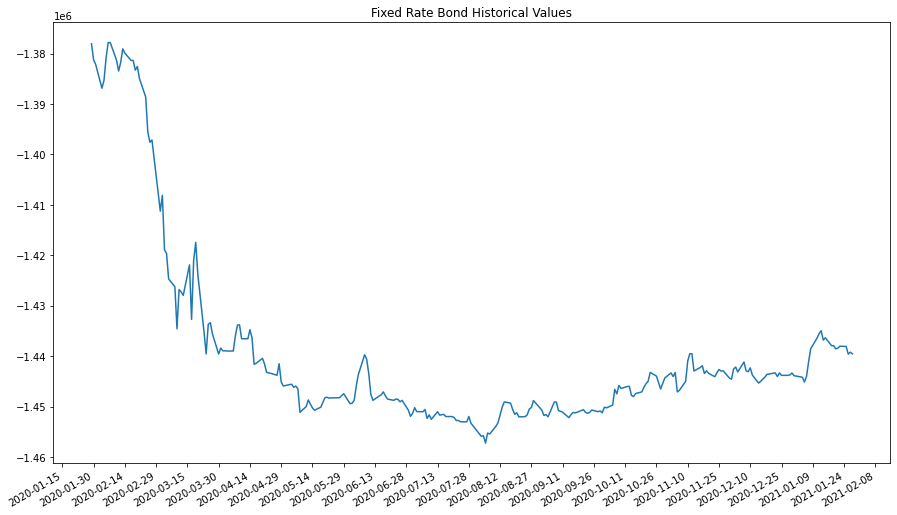

In [10]:
converted_dates = list(map(datetime.datetime.strptime, portfoliohistoricaldates, len(portfoliohistoricaldates)*['%Y-%m-%d']))
plt.figure(figsize=(15,9))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))
plt.gcf().autofmt_xdate()
plt.plot(converted_dates, portfoliohistoricalvalues)
plt.title("Fixed Rate Bond Historical Values")
plt.show()

In [11]:
###################################################################################################
###################################################################################################
###################################################################################################
###################################################################################################
###################################################################################################
###################################################################################################
###################################################################################################
###################################################################################################

In [12]:
riskdata["method"]="risk_factors"

In [13]:
try:
    res = api.createTask(CalculationType.PORTFOLIO, riskdata, True)
    if(res["result"]):
        rfresult=json.loads(res["result"])
    else:
        print(res["result"])
except RhoovaError as e:
    e.printPretty()

In [17]:
lastdf=pd.DataFrame(rfresult)

In [18]:
###################################################################################################
###################################################################################################
###################################################################################################
###################################################################################################
###################################################################################################
###################################################################################################
###################################################################################################


In [19]:
fxedratebonddata = {
  "notional": 1000000,
  "valuationDate": "2021-01-28",
  "settlementDate": "2021-02-01",
  "buySell": "Sell",
  "fixedRateBondDefinition": fixedRateBondDefinition,
  "discountCurve": yieldcurveconfig,
  "yieldData": yielddata.to_dict('r')
}

In [20]:
historicalvalues=[]
historicaldates=[]
for index, row in lastdf.iterrows():
    y_data=yielddata[yielddata['valuationDate']==index]
    y_data['valuationDate']='2021-01-28'
    fxedratebonddata['yieldData']=json.loads(y_data.to_json(orient='records'))
    try:
        resultdata = api.createTask(CalculationType.FIXED_RATE_BOND, fxedratebonddata,True)
        resulttmp=json.loads(resultdata["result"])
    except RhoovaError as e:
        e.printPretty()
    historicaldates.append(index)    
    historicalvalues.append(resulttmp.get('pv'))


In [21]:
confidenceInterval= 0.99
valueatrisk=result.get('pv')-np.percentile(historicalvalues[:-1],100*(1-confidenceInterval))

In [22]:
npvTable = pt.PrettyTable(['Parameters', 'Value'])
npvTable.add_row(['PV', result.get('pv')])
npvTable.add_row(['VAR', valueatrisk])
npvTable.add_row(['VAR/PV (%)', 100*valueatrisk/abs(result.get('pv'))])
npvTable.align = 'r'
npvTable.float_format = '.4'
print(npvTable)


+------------+---------------+
| Parameters |         Value |
+------------+---------------+
|         PV | -1439540.9774 |
|        VAR |    16051.0888 |
| VAR/PV (%) |        1.1150 |
+------------+---------------+


In [23]:
###################################################################################################
###################################################################################################
###################################################################################################
###################################################################################################
###################################################################################################
###################################################################################################
###################################################################################################
###################################################################################################
###################################################################################################


In [24]:
datelist=['2021-02-01','2021-02-02','2021-02-08','2021-02-15','2021-02-22','2021-03-01','2021-04-01','2021-05-03',
          '2021-08-02','2021-11-01','2022-02-01','2023-02-01','2024-02-01','2025-02-03','2026-02-02','2027-02-01',
          '2028-02-01','2029-02-01','2030-02-01','2031-02-03','2033-02-01','2036-02-01','2041-02-01','2046-02-01',
          '2051-02-01','2061-02-01','2071-02-02']

In [25]:
rf=dict(zip(lastdf.columns, datelist))
rf

{'TRYZC0D': '2021-02-01',
 'TRYZC1D': '2021-02-02',
 'TRYZC1W': '2021-02-08',
 'TRYZC2W': '2021-02-15',
 'TRYZC3W': '2021-02-22',
 'TRYZC1M': '2021-03-01',
 'TRYZC2M': '2021-04-01',
 'TRYZC3M': '2021-05-03',
 'TRYZC6M': '2021-08-02',
 'TRYZC9M': '2021-11-01',
 'TRYZC1Y': '2022-02-01',
 'TRYZC2Y': '2023-02-01',
 'TRYZC3Y': '2024-02-01',
 'TRYZC4Y': '2025-02-03',
 'TRYZC5Y': '2026-02-02',
 'TRYZC6Y': '2027-02-01',
 'TRYZC7Y': '2028-02-01',
 'TRYZC8Y': '2029-02-01',
 'TRYZC9Y': '2030-02-01',
 'TRYZC10Y': '2031-02-03',
 'TRYZC12Y': '2033-02-01',
 'TRYZC15Y': '2036-02-01',
 'TRYZC20Y': '2041-02-01',
 'TRYZC25Y': '2046-02-01',
 'TRYZC30Y': '2051-02-01',
 'TRYZC40Y': '2061-02-01',
 'TRYZC50Y': '2071-02-02'}

In [26]:
yielddata_lst=[]
for index, row in lastdf.iterrows():
    for key,val in row.items():
        yielddata_dict={}
        yielddata_dict["valuationDate"]=index
        yielddata_dict["maturityDate"]=rf[key]
        yielddata_dict["value"]=val
        yielddata_dict["instrument"]="USDZeroRates"
        yielddata_dict["currency"]="USD"
        yielddata_dict["settlementDate"]=""
        yielddata_dict["period"]="6M"
        yielddata_dict["tenor"]=""
        yielddata_lst.append(yielddata_dict)

In [27]:
# Fix parameters for building yield curve
yieldcurveconfig2={
        "name": "TRYZC",
        "settlementDays": 2,
        "intpMethod": "LINEAR",
        "currency": "USD",
        "calendar": "Turkey",
        "dayCounter": "Actual360",
        "zeroRates": "USDZeroRates",
        "period":"6M"
    }

In [28]:
data2 = {
  "notional": 1000000,
  "valuationDate": "2021-01-28",
  "settlementDate": "2021-02-01",
  "buySell": "Sell",
  "fixedRateBondDefinition": fixedRateBondDefinition,
  "discountCurve": yieldcurveconfig2,
  "yieldData": yielddata_lst
}

In [29]:
try:
    resultdata = api.createTask(CalculationType.FIXED_RATE_BOND, data2,True)
    result=json.loads(resultdata["result"])
except RhoovaError as e:
    e.printPretty()

In [30]:
npvTable = pt.PrettyTable(['Parameters', 'Value'])
npvTable.add_row(['PV', result.get('pv')])
npvTable.add_row(['Clean Price', result.get('cleanPrice')])
npvTable.add_row(['Dirty Price', result.get('dirtyPrice')])
npvTable.add_row(['Accrued Amount', result.get('accruedAmount')])
npvTable.add_row(['Yield to Maturity', 100*result.get('yieldToMaturity')])
npvTable.add_row(['Duration', result.get('duration')])
npvTable.add_row(['Modified Duration', result.get('modifiedDuration')])
npvTable.add_row(['Macualay Duration', result.get('macaulayDuration')])
npvTable.add_row(['Convexity', result.get('convexity')])
npvTable.add_row(['Bps', result.get('bps')])
npvTable.align = 'r'
npvTable.float_format = '.4'
print(npvTable)

+-------------------+---------------+
|        Parameters |         Value |
+-------------------+---------------+
|                PV | -1439189.5361 |
|       Clean Price |      142.5259 |
|       Dirty Price |      143.9190 |
|    Accrued Amount |        1.3931 |
| Yield to Maturity |        0.5227 |
|          Duration |        4.5867 |
| Modified Duration |        4.5748 |
| Macualay Duration |        4.5867 |
|         Convexity |       25.4566 |
|               Bps |        0.0549 |
+-------------------+---------------+


In [31]:
historicalvalues2=[]
historicaldates2=[]
yielddata_lst_df=pd.DataFrame(yielddata_lst)
for index, row in lastdf.iterrows():
    y_data=yielddata_lst_df[yielddata_lst_df['valuationDate']==index]
    y_data['valuationDate']='2021-01-28'
    data2['yieldData']=json.loads(y_data.to_json(orient='records'))
    try:
        resultdata = api.createTask(CalculationType.FIXED_RATE_BOND, data2,True)
        resulttmp=json.loads(resultdata["result"])
    except RhoovaError as e:
        e.printPretty()
    historicaldates2.append(index)    
    historicalvalues2.append(resulttmp.get('pv'))
    #print(index,resulttmp.get('pv'))    


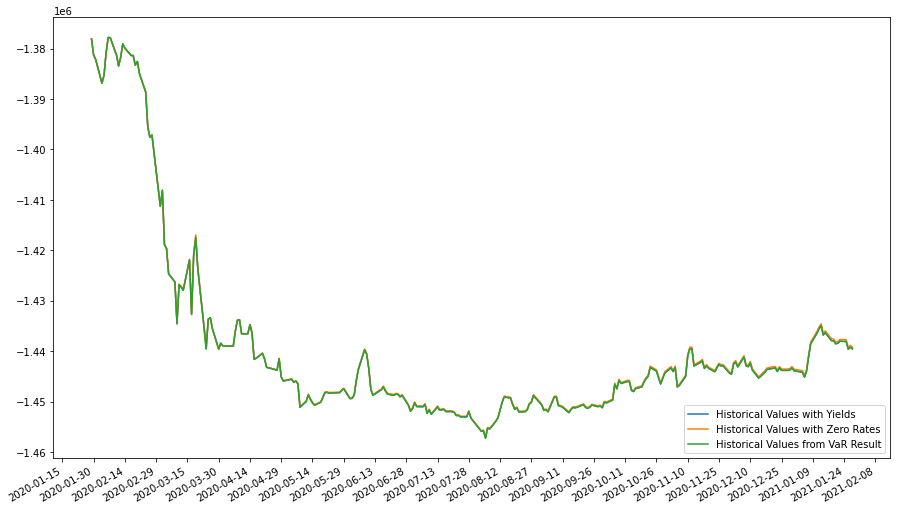

In [32]:
converted_dates = list(map(datetime.datetime.strptime, historicaldates, len(historicaldates)*['%Y-%m-%d']))
plt.figure(figsize=(15,9))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))
plt.gcf().autofmt_xdate()
plt.plot(converted_dates[:-1], historicalvalues[:-1])
plt.plot(converted_dates[:-1], historicalvalues2[:-1])
plt.plot(converted_dates[:-1], portfoliohistoricalvalues)
plt.legend(["Historical Values with Yields", "Historical Values with Zero Rates","Historical Values from VaR Result"], loc ="lower right")
plt.show()

In [33]:
valueatrisk=result.get('pv')-np.percentile(historicalvalues[:-1],100*(1-0.99))


In [34]:
npvTable = pt.PrettyTable(['Parameters', 'Value'])
npvTable.add_row(['PV', result.get('pv')])
npvTable.add_row(['VAR', valueatrisk])
npvTable.add_row(['VAR/PV (%)', 100*valueatrisk/abs(result.get('pv'))])
npvTable.align = 'r'
npvTable.float_format = '.4'
print(npvTable)


+------------+---------------+
| Parameters |         Value |
+------------+---------------+
|         PV | -1439189.5361 |
|        VAR |    16402.5300 |
| VAR/PV (%) |        1.1397 |
+------------+---------------+
